# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('D:\\GitHub\\Coursera\\Tensorflow2forDeepLearning\\GettingStartedWithTensorFlow2\\Week5\\data\\train_32x32.mat')
test = loadmat('D:\\GitHub\\Coursera\\Tensorflow2forDeepLearning\\GettingStartedWithTensorFlow2\\Week5\\data\\test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
# Extract training and testing images and labels
x_train = train['X'] / 255.
x_test = test['X'] /255.

y_train = train['y']
y_test = test['y'] 

In [4]:
for iTrain in range(len(y_train)):
    if y_train[iTrain] == 10:
        y_train[iTrain] = 0

for iTest in range(len(y_test)):
    if y_test[iTest] == 10:
        y_test[iTest] = 0

In [5]:
x_train = np.moveaxis(x_train,3,0)

x_test  = np.moveaxis(x_test,3,0)

x_train.shape

(73257, 32, 32, 3)

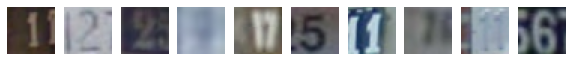

In [6]:
# Display random sample of images and labels

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    random_inx = np.random.choice(x_train.shape[0])

    ax[i].set_axis_off()
    ax[i].imshow(x_train[random_inx])

In [7]:
x_train_gray = np.average(x_train, axis=3, keepdims = True)
x_test_gray = np.average(x_test, axis=3, keepdims = True)

x_train_gray.shape

(73257, 32, 32, 1)

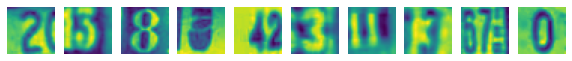

In [8]:
# Display random sample of images and labels

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    random_inx = np.random.choice(x_train_gray.shape[0])

    ax[i].set_axis_off()
    ax[i].imshow(x_train_gray[random_inx])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
# Build the Sequential feedforward neural network model
model = Sequential([
    Flatten(input_shape=(32,32,1), name='flatten_1'),
    Dense(128, activation='relu',name='dense_layer_1'),
    Dense(64, activation='relu',name='dense_layer_2'),
    Dense(64, activation='relu', name='dense_layer_3'),
    Dense(10, activation='softmax', name='output_layer')
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_layer_1 (Dense)       (None, 128)               131200    
                                                                 
 dense_layer_2 (Dense)       (None, 64)                8256      
                                                                 
 dense_layer_3 (Dense)       (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 144,266
Trainable params: 144,266
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile the model

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
# Create Tensorflow checkpoint object

checkpoint_best_path = 'model_checkpoints_best\\checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path, save_weights_only=True, save_freq='epoch', monitor='loss',
                                    save_best_only=True, verbose=1)

In [12]:
class TrainingCallback(Callback):

    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")


In [13]:
# Train the model, with some of the data reserved for validation

history = model.fit(x_train_gray, y_train, epochs=30, validation_split=0.15, batch_size=64, callbacks=[TrainingCallback(), checkpoint_best, tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)], verbose=True)

Starting epoch 0
Epoch 1/30
959/973 [============================>.] - ETA: 0s - loss: 2.0862 - accuracy: 0.2532
Epoch 1: loss improved from inf to 2.07951, saving model to model_checkpoints_best\checkpoint
973/973 [==============================] - 2s 2ms/step - loss: 2.0795 - accuracy: 0.2559 - val_loss: 1.5865 - val_accuracy: 0.4619
Starting epoch 1
Epoch 2/30
964/973 [============================>.] - ETA: 0s - loss: 1.3869 - accuracy: 0.5410
Epoch 2: loss improved from 2.07951 to 1.38615, saving model to model_checkpoints_best\checkpoint
973/973 [==============================] - 2s 2ms/step - loss: 1.3862 - accuracy: 0.5414 - val_loss: 1.2672 - val_accuracy: 0.5943
Starting epoch 2
Epoch 3/30
950/973 [============================>.] - ETA: 0s - loss: 1.1889 - accuracy: 0.6229
Epoch 3: loss improved from 1.38615 to 1.18634, saving model to model_checkpoints_best\checkpoint
973/973 [==============================] - 2s 2ms/step - loss: 1.1863 - accuracy: 0.6239 - val_loss: 1.1222 -

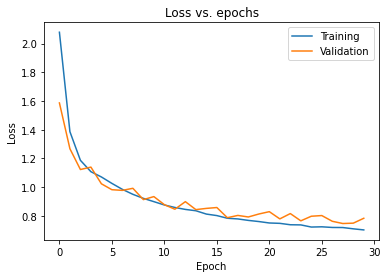

In [14]:
# Plot the training and validation loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

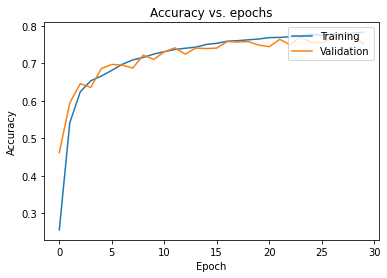

In [15]:
# Plot the training and validation accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [16]:
model.evaluate(x_test_gray, y_test, verbose=2)

814/814 - 1s - loss: 0.8815 - accuracy: 0.7351 - 747ms/epoch - 917us/step


[0.8814964294433594, 0.735133707523346]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [17]:
model2 = Sequential([
        Conv2D(32,(3,3),activation='relu',input_shape=(32,32,1)),
        MaxPooling2D((3,3)),
        Dense(32,  activation="relu",),
        BatchNormalization(),
        Conv2D(16,(3,3),activation='relu'),
        Dense(16,  activation="relu"),
        Dropout(0.3),
        Flatten(),
        Dense(10, activation='softmax', name='output_layer')
        ])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 dense (Dense)               (None, 10, 10, 32)        1056      
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 dense_1 (Dense)             (None, 8, 8, 16)         

In [18]:
# Compile the model

model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
# Create Tensorflow checkpoint object

checkpoint_best_path_CNN = 'model_checkpoints_best_CNN\\checkpoint'
checkpoint_best_CNN = ModelCheckpoint(filepath=checkpoint_best_path_CNN, save_weights_only=True, save_freq='epoch', monitor='val_accuracy',
                                    save_best_only=True, verbose=1)

In [20]:
class TrainingCallback_CNN(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")

In [21]:
# Train the model, with some of the data reserved for validation

history2 = model2.fit(x_train_gray, y_train, epochs=30, validation_split=0.15, batch_size=64, callbacks=[TrainingCallback_CNN(), checkpoint_best_CNN, tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)], verbose=True)

Starting epoch 0
Epoch 1/30
972/973 [============================>.] - ETA: 0s - loss: 0.8941 - accuracy: 0.7149Finished epoch 0

Epoch 1: val_accuracy improved from -inf to 0.80608, saving model to model_checkpoints_best_CNN\checkpoint
973/973 [==============================] - 24s 24ms/step - loss: 0.8940 - accuracy: 0.7149 - val_loss: 0.6451 - val_accuracy: 0.8061
Starting epoch 1
Epoch 2/30
972/973 [============================>.] - ETA: 0s - loss: 0.5567 - accuracy: 0.8349Finished epoch 1

Epoch 2: val_accuracy did not improve from 0.80608
973/973 [==============================] - 22s 23ms/step - loss: 0.5574 - accuracy: 0.8349 - val_loss: 0.9315 - val_accuracy: 0.7291
Starting epoch 2
Epoch 3/30
972/973 [============================>.] - ETA: 0s - loss: 0.5117 - accuracy: 0.8472Finished epoch 2

Epoch 3: val_accuracy improved from 0.80608 to 0.80644, saving model to model_checkpoints_best_CNN\checkpoint
973/973 [==============================] - 25s 25ms/step - loss: 0.5116 - ac

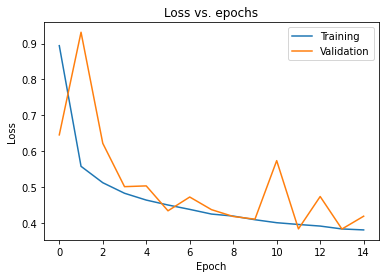

In [22]:
# Plot the training and validation loss 

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

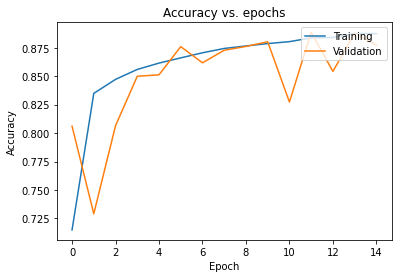

In [23]:
# Plot the training and validation accuracy

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [24]:
# Evaluate the model on the test set

model2.evaluate(x_test_gray, y_test, verbose=2)

814/814 - 4s - loss: 0.4522 - accuracy: 0.8735 - 4s/epoch - 5ms/step


[0.4521860182285309, 0.8735018372535706]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [25]:
# Load MLP
checkpoint_best_path = 'model_checkpoints_best\\checkpoint'
model.load_weights(checkpoint_best_path)

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [26]:
# Load CNN
checkpoint_best_path_CNN = 'model_checkpoints_best_CNN\\checkpoint'
model2.load_weights(checkpoint_best_path_CNN)

model2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

1/1 [==============================] - 0s 117ms/step
[[4.0151618e-04 9.6642381e-01 4.5870664e-03 1.9589698e-02 2.0854585e-03
  1.0726645e-03 3.1256038e-04 1.8664163e-03 3.3767954e-03 2.8399273e-04]]
1/1 [==============================] - 0s 23ms/step
[[5.4246688e-05 7.9295406e-04 4.4941436e-03 7.7260339e-01 2.5668326e-03
  9.3385279e-02 1.5991081e-02 7.6208606e-05 6.6653013e-02 4.3382820e-02]]
1/1 [==============================] - 0s 19ms/step
[[1.0061639e-02 1.7648257e-02 6.1293389e-04 2.7950797e-03 9.6180940e-01
  1.1990687e-03 1.5086278e-03 9.4557035e-05 1.9977381e-03 2.2725926e-03]]
1/1 [==============================] - 0s 20ms/step
[[0.00642895 0.00254689 0.01497933 0.12251862 0.00096914 0.79554075
  0.00567877 0.02474732 0.00163968 0.02495056]]
1/1 [==============================] - 0s 19ms/step
[[5.7233032e-04 2.9524481e-02 9.6832275e-02 7.6102531e-01 9.3449436e-02
  1.7505141e-02 2.5802964e-04 3.5080884e-04 4.0504738e-04 7.7069242e-05]]
1/1 [==============================] - 

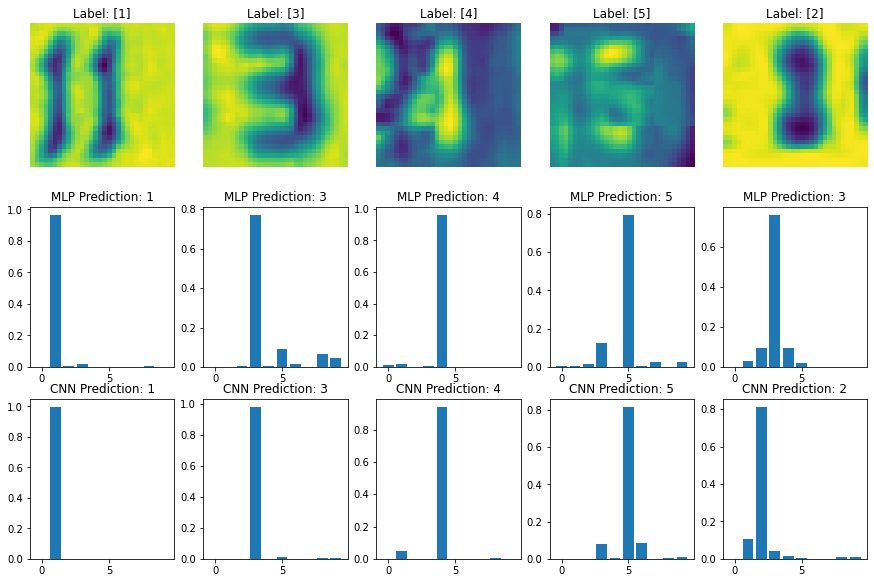

In [27]:
# Display random sample of images and labels


fig, ax = plt.subplots(3, 5, figsize=(15, 10))
for i in range(5):
    random_inx = np.random.choice(x_test_gray.shape[0])

    ax[0,i].set_axis_off()
    ax[0,i].imshow(x_test_gray[random_inx])
    ax[0,i].set_title(f"Label: {y_test[random_inx]}")

    preds = model.predict(x_test_gray[random_inx][np.newaxis, ...])
    print(preds)
    ax[1,i].bar(list(range(0,10)),preds[0])
    ax[1,i].set_title(f"MLP Prediction: {preds.argmax()}")

    preds2 = model2.predict(x_test_gray[random_inx][np.newaxis, ...])
    ax[2,i].bar(list(range(0,10)),preds2[0])
    ax[2,i].set_title(f"CNN Prediction: {preds2.argmax()}")